In [1]:
import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,plot_roc_curve
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import imodels
from rulevetting.api import validation, util as api_util
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting import DATA_PATH
np.random.seed(0)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data
To be able to connect the data from different datasets, we keep CaseID, ControlType and SubjectID.

To do this, you need to mannuly change "feats = df.keys()[4:]" in datatset.py::extract_features to "feats = df.keys()[1:]"

In [51]:
df_train, df_tune, df_test = Dataset().get_data(save_csvs=True,load_csvs=False)
outcome_def = 'outcome'  # output
meta_keys = api_util.get_feat_names_from_base_feats(df_train.columns, Dataset().get_meta_keys())

X_train = df_train.drop(columns=meta_keys).drop(columns='CaseID').drop(columns='ControlType')
X_tune = df_tune.drop(columns=meta_keys).drop(columns='CaseID').drop(columns='ControlType')
X_test = df_test.drop(columns=meta_keys).drop(columns='CaseID').drop(columns='ControlType')

y_train = X_train[outcome_def].values
X_train = X_train.drop(columns=[outcome_def])
y_tune = X_tune[outcome_def].values
X_tune = X_tune.drop(columns=[outcome_def])
y_test = X_test[outcome_def].values
X_test = X_test.drop(columns=[outcome_def])

X_train_all=pd.concat((X_train, X_tune))
y_train_all=np.concatenate((y_train, y_tune))

X_all=pd.concat((X_train, X_tune, X_test))
y_all=np.concatenate((y_train, y_tune, y_test))

processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats
# X_train_all.head

kwargs {'clean_data': {'include_intervention': True}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': False, 'augmented_features': True, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


# Create the best model 
The best model is RuleFitClassifier with hyperparameters max_rules=13, n_estimators=50,  include_linear=True, cv=False,random_state=0
Prerequirement: imodel package needs to be updated.

In [52]:
rulefit = imodels.RuleFitClassifier(max_rules=13, n_estimators=50,  include_linear=True, cv=False,random_state=0)
rulefit.fit(X_train_all, y_train_all, feature_names=feature_names)

RuleFitClassifier(cv=False, max_rules=13, n_estimators=50, random_state=0)

# Rules

In [6]:
rulefit.visualize()

,rule,coef
29,PtCompPainHead2,-0.02
37,Immobilization2,0.24
49,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5 and HighriskDiving <= 0.5,-0.16
47,FocalNeuroFindings2 <= 0.5 and subinj_TorsoTrunk2 <= 0.5 and HighriskDiving <= 0.5,-0.01
50,subinj_TorsoTrunk2 <= 0.5 and MedsRecd2 <= 0.5 and ArrPtIntub2 <= 0.5,-0.65
52,FocalNeuroFindings2 <= 0.5 and HighriskDiving <= 0.5 and HighriskMVC <= 0.5,-0.29
51,FocalNeuroFindings2 <= 0.5 and is_ems > 0.5,-0.48
45,axialloadtop <= 0.5 and FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5 and ArrPtIntub2 <= 0.5 and HighriskMVC <= 0.5,-0.43
48,AlteredMentalStatus2 <= 0.5 and FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,-0.62
46,PainNeck2 <= 0.5 and Predisposed <= 0.5 and ArrPtIntub2 <= 0.5,-0.69


# PR curve and choose the threshold

# When sensitivity = 96.6  and specificity=35.4

/Users/yuhaod/Desktop/csi/rule-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


choose threshold: 0.0019728743590615395
sensitivity: 0.9661016949152542
specificity: 0.354632587859425


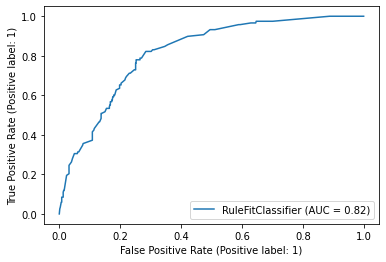

In [53]:
X_test= check_array(X_test)
prediction_prob=rulefit.predict_proba(X_test)
fpr, tpr, threshold_lists=roc_curve(y_test, prediction_prob[:,1])
sensitivity=tpr
specificity=1-fpr
plot_roc_curve(rulefit, X_test, y_test) 
thres=-15 # index for threshold

print(f'choose threshold: {threshold_lists[thres]}')
print(f'sensitivity: {sensitivity[thres]}')
print(f'specificity: {specificity[thres]}')

## Prediction and find the indices of false negative 

In [54]:
prediction=prediction_prob[:,1] >= threshold_lists[thres]
# print(f'number of predicted positive: {sum(prediction)}')
# print(f'number of true positive: {sum(y_all)}')
false_negative_idx=[]
for idx, (first,second) in enumerate(zip(prediction,y_test)):
    if first==0 and second==1:
        false_negative_idx.append(idx)
print(f'number of false negative: {len(false_negative_idx)}')

number of false negative: 4


## Check the meta-keys for the false negative cases

In [58]:
X_train_meta = df_train[meta_keys+['CaseID']]
X_tune_meta = df_tune[meta_keys+['CaseID']]
X_test_meta = df_test[meta_keys+['CaseID']]
X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index().drop(columns='SITE').drop(columns='index').drop(columns='StudySubjectID')
cols = X_all_meta.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_all_meta = X_all_meta[cols]
# 
X_all_meta=X_all_meta.loc[:, X_all_meta.any()].dropna(axis=1,how='all')
X_false_negative_meta=X_all_meta.iloc[false_negative_idx].loc[:, X_all_meta.any()]
X_false_negative_meta.reset_index(drop=True, inplace=True)
X_false_negative_meta['CaseID']=X_false_negative_meta['CaseID'].apply(np.int64)
X_false_negative_meta.sort_values(by=['CaseID'])

,CaseID,EDDisposition,IntervForCervicalStab,IntervForCervicalStabBrace,IntervForCervicalStabHalo,IntervForCervicalStabIntFix,IntervForCervicalStabIntFixtxt,IntervForCervicalStabOther,IntervForCervicalStabOthertxt,IntervForCervicalStabRCollar,IntervForCervicalStabSCollar,IntervForCervicalStabSurgical,IntervForCervicalStabTraction,LongTermRehab,OutcomeStudySiteBowel,OutcomeStudySiteMobility,OutcomeStudySiteMobility1,OutcomeStudySiteMobility2,OutcomeStudySiteNeuro,OutcomeStudySiteUrine
2,410466,HOME,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
3,710857,GEN,Y,0,1,1,C1-C2 posterior fusion,0,0,1,0,1,0,Y,0,0,0,0,0,0
1,1011642,GEN,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
0,1111837,ICU,Y,0,0,0,0,0,0,1,0,0,0,Y,N,DA,0,0,MD,N


# Check injuryclassification.csv


In [59]:
CaseID=[]
for i in df_train.iloc[false_negative_idx]['CaseID'].tolist():
    CaseID.append(int(i))
df_injury=pd.read_csv('/Users/yuhaod/Desktop/csi/rule-vetting/data/csi_pecarn/raw/injuryclassification.csv')
df_injury=df_injury.loc[ df_injury['CaseID'].isin(CaseID)].drop(columns='ControlType').drop(columns='SITE').drop(columns='StudySubjectID')
# .drop(columns='CaseID').drop(columns='ControlType').drop(columns='StudySubjectID').drop(columns='SITE')
df_injury=df_injury.loc[:, df_injury.any()].dropna(axis=1,how='all')
df_injury.reset_index(drop=True, inplace=True)
df_injury.sort_values(by=['CaseID'])
# X_tune_meta = df_tune[meta_keys]
# X_test_meta = df_test[meta_keys]
# X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index()

,CaseID,CSFractures,CFracturesC2,C2SbFractureBOOT,C2SbFractureBOOTypeOR,C2SbFractureBOOTypeORtxt,Ligamentoptions,LigamentousInjuryOAD,LigamentousInjuryC23,C2_3SbLigSL,C2_3SbLigAL,LigamentousInjuryC56,C5_6SbLigSC,C5_6SbLigSCWSC,LigamentousInjuryC7T1,C7_T1SbLigSC,C7_T1SbLigSCPL,CSpineSignalChange,SignalChangeLevelC5,SignalChangeLevelC6,SignalChangeLevelC7,CordInjuryNoRadiographic
0,410466,N,0,0,0,NaN,Y,0,1,1,1,0,0,0,0,0,0,N,0,0,0,N
1,710857,Y,1,1,1,synchondroses,N,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,N
2,1011642,N,0,0,0,NaN,Y,1,0,0,0,0,0,0,0,0,0,NaN,0,0,0,N
3,1111837,N,0,0,0,NaN,Y,0,0,0,0,1,1,1,1,1,1,Y,1,1,1,N


# When sensitivity = 89.8  and specificity=57.8

choose threshold: 0.002984822728084481
sensitivity: 0.8983050847457628
specificity: 0.5782747603833867


/Users/yuhaod/Desktop/csi/rule-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


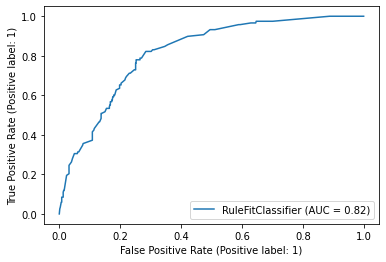

In [60]:
X_test= check_array(X_test)
prediction_prob=rulefit.predict_proba(X_test)
fpr, tpr, threshold_lists=roc_curve(y_test, prediction_prob[:,1])
sensitivity=tpr
specificity=1-fpr
plot_roc_curve(rulefit, X_test, y_test) 
thres=-25 # index for threshold

print(f'choose threshold: {threshold_lists[thres]}')
print(f'sensitivity: {sensitivity[thres]}')
print(f'specificity: {specificity[thres]}')

## Prediction and find the indices of false negative 

In [61]:
prediction=prediction_prob[:,1] >= threshold_lists[thres]
# print(f'number of predicted positive: {sum(prediction)}')
# print(f'number of true positive: {sum(y_all)}')
false_negative_idx=[]
for idx, (first,second) in enumerate(zip(prediction,y_test)):
    if first==0 and second==1:
        false_negative_idx.append(idx)
print(f'number of false negative: {len(false_negative_idx)}')

number of false negative: 12


## Check the meta-keys for the false negative cases

In [62]:
X_train_meta = df_train[meta_keys+['CaseID']]
X_tune_meta = df_tune[meta_keys+['CaseID']]
X_test_meta = df_test[meta_keys+['CaseID']]
X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index().drop(columns='SITE').drop(columns='index').drop(columns='StudySubjectID')
cols = X_all_meta.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_all_meta = X_all_meta[cols]
# 
X_all_meta=X_all_meta.loc[:, X_all_meta.any()].dropna(axis=1,how='all')
X_false_negative_meta=X_all_meta.iloc[false_negative_idx].loc[:, X_all_meta.any()]
X_false_negative_meta.reset_index(drop=True, inplace=True)
X_false_negative_meta['CaseID']=X_false_negative_meta['CaseID'].apply(np.int64)
X_false_negative_meta.sort_values(by=['CaseID'])

,CaseID,EDDisposition,IntervForCervicalStab,IntervForCervicalStabBrace,IntervForCervicalStabHalo,IntervForCervicalStabIntFix,IntervForCervicalStabIntFixtxt,IntervForCervicalStabOther,IntervForCervicalStabOthertxt,IntervForCervicalStabRCollar,IntervForCervicalStabSCollar,IntervForCervicalStabSurgical,IntervForCervicalStabTraction,LongTermRehab,OutcomeStudySiteBowel,OutcomeStudySiteMobility,OutcomeStudySiteMobility1,OutcomeStudySiteMobility2,OutcomeStudySiteNeuro,OutcomeStudySiteUrine
7,410466,HOME,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
4,410474,HOME,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
3,410481,GEN,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
9,710857,GEN,Y,0,1,1,C1-C2 posterior fusion,0,0,1,0,1,0,Y,0,0,0,0,0,0
1,710864,HOME,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
11,911492,HOME,Y,0,0,0,0,0,0,0,1,0,0,N,0,0,0,0,0,0
6,1011642,GEN,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
5,1111837,ICU,Y,0,0,0,0,0,0,1,0,0,0,Y,N,DA,0,0,MD,N
2,1312191,ICU,Y,0,1,0,0,0,0,1,0,1,0,N,I,I,0,0,SD,C
10,1312193,ICU,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0


# Check injury classification


In [63]:
CaseID=[]
for i in df_train.iloc[false_negative_idx]['CaseID'].tolist():
    CaseID.append(int(i))
df_injury=pd.read_csv('/Users/yuhaod/Desktop/csi/rule-vetting/data/csi_pecarn/raw/injuryclassification.csv')
df_injury=df_injury.loc[ df_injury['CaseID'].isin(CaseID)].drop(columns='ControlType').drop(columns='SITE').drop(columns='StudySubjectID')
# .drop(columns='CaseID').drop(columns='ControlType').drop(columns='StudySubjectID').drop(columns='SITE')
df_injury=df_injury.loc[:, df_injury.any()].dropna(axis=1,how='all')
df_injury.reset_index(drop=True, inplace=True)
df_injury.sort_values(by=['CaseID'])
# X_tune_meta = df_tune[meta_keys]
# X_test_meta = df_test[meta_keys]
# X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index()

,CaseID,CSFractures,CFracturesC2,C2SbFractureBOOT,C2SbFractureBOOTypeOR,C2SbFractureBOOTypeORtxt,CFracturesC4,C4SbFractureBY,C4SbFractureBYWC,C4SbFractureBYLH,C4SbFractureBYOR,C4SbFractureBYORtxt,CFracturesC5,C5SbFractureBY,C5SbFractureBYWC,C5SbFractureBYB,C5SbFractureBYLH,C5SbFractureFT,C5SbFractureFTType,C5SbFractureLA,C5SbFractureCC,CFracturesC7,C7SbFractureBY,C7SbFractureBYWC,C7SbFractureTP,Ligamentoptions,LigamentousInjuryOAD,LigamentousInjuryC12,C1_2SbLigSL,C1_2SbLigSLARS,LigamentousInjuryC23,C2_3SbLigSL,C2_3SbLigAL,LigamentousInjuryC34,C3_4SbLigSC,C3_4SbLigSCAL,LigamentousInjuryC45,C4_5SbLigSC,C4_5SbLigSCAL,LigamentousInjuryC56,C5_6SbLigSL,C5_6SbLigSC,C5_6SbLigSCWSC,C5_6SbLigSCPL,LigamentousInjuryC7T1,C7_T1SbLigSC,C7_T1SbLigSCPL,CSpineSignalChange,SignalChangeLevelC4,SignalChangeLevelC5,SignalChangeLevelC6,SignalChangeLevelC7,CordInjuryNoRadiographic
0,410466,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,Y,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,N
1,410474,Y,0,0,0,NaN,1,1,1,1,0,NaN,1,1,1,0,1,0,NaN,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,Y,1,0,0,0,N
2,410481,Y,0,0,0,NaN,0,0,0,0,0,NaN,1,0,0,0,0,1,U,1,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,NaN,0,0,0,0,N
3,710857,Y,1,1,1,synchondroses,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,N
4,710864,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,Y,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,N
5,911492,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,Y
6,1011642,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,Y,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,N
7,1111837,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,Y,0,1,1,1,N
8,1312191,N,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,0,0,0,0,Y,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,N
9,1312193,Y,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,NaN,0,0,1,0,0,1,Y,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,N
